# Gradient Bandit Method Implemented in Incorrect way.
I realized the mistake while I was reading the section again :-).

I am still leaving this notebook to show that flaw. Try to spot the flaw else **Check Part-6 for correct Method**.

The result almost look the same as given in Book but We are doing a serious mistake While implementing the algorithm.

# Theory Section ( Don't look for any flaw in it :-) )
In this section we consider learning a numerical preference for each action
$a$, which we denote $H_t (a)$. The larger the preference, the more often that action is taken,
but the preference has no interpretation in terms of reward. Only the relative preference
of one action over another is important;

\begin{equation*}
\Pr  \{ A_t = a \} \approx \frac { \exp^{H_t(a)} } { \sum_{b=1}^k \exp^{H_t(b)}} \approx \pi_t(a)
\end{equation*}

where \begin{align*} \pi_t(a) \end{align*} is the probability of taking action a at time t and


$H_1$(a) = 0 for all a

There is a natural learning algorithm for this setting based on the idea of stochastic
gradient ascent. On each step, after selecting action $A_t$ and receiving the reward  $R_t$ , the
action preferences are updated by :


\begin{equation*}
H_{t+1}(A_t)  = H_t(A_t) + \alpha  (R_t - \overline{R_t}) ( 1 - \pi_t(A_t)) \space  and  \\
H_{t+1}(a)  = H_t(a) + \alpha  (R_t - \overline{R_t}) ( \pi_t(a))\space \forall a \ne A_t
\end{equation*}

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import __version__ as matplotlib_version

In [2]:
print("numpy version - ", np.__version__)
print("matplotlib version - ", matplotlib_version)

numpy version -  1.17.4
matplotlib version -  3.2.1


In [3]:
import multiprocessing

In [4]:
def softmax_distribution(preference_estimates):
    maxval = np.amax(preference_estimates)
    exps = np.exp(preference_estimates - maxval) # Using Property of Softmax function
    
    return  exps / np.sum( exps,axis=0 )

def gradient_bandit(steps, n_bandit, n_lever, step_size,is_baseline_applied,
          testbed, initial_reward_estimates, global_reward_list):
    
    action_count = np.ones((n_bandit,n_lever))  # each lever is pulled atleast once
    Ravg = np.zeros((n_bandit,n_lever))  # avg_reward_estimates
    Hpref = np.zeros((n_bandit, n_lever)) # preference_estimates
    pr_a_t = np.zeros((n_bandit, n_lever)) # probability of action a at time t

    
    optimal_choice_per_step = []
    optimal_choice_per_step.append(10) # 10% chance of selecting optimal lever in first go
    
    for step in range(1,steps):
        sum_of_optimal_choice = 0 
        for problem_index in range(n_bandit):  
            pr_a_t[problem_index] = softmax_distribution(Hpref[problem_index])
            chosen_action = np.random.choice(np.arange(n_lever), p = pr_a_t[problem_index])
            
            if chosen_action == np.argmax(testbed[problem_index]):
                sum_of_optimal_choice += 1
            
            # Incremental Algorithm
            Rn = np.random.normal(testbed[problem_index][chosen_action],1)
            n = action_count[problem_index] [chosen_action]
            Qn = Ravg[problem_index][chosen_action]  
            
            Qnew = ( Rn + (n - 1) * Qn ) / n
            
            
           # Updates of our parameters
            for action_index in range(n_lever):
                if action_index != chosen_action :
                    Hpref[problem_index][action_index] = Hpref[problem_index][action_index] - ( step_size * (Rn - Ravg[problem_index][action_index]) * pr_a_t[problem_index][action_index] )
                else:
                    Hpref[problem_index][action_index] = Hpref[problem_index][action_index] +  ( step_size * (Rn - Ravg[problem_index][action_index])  * (1 - pr_a_t[problem_index][action_index] ) ) 
                            
            if is_baseline_applied == True:
                Ravg[problem_index][chosen_action] = Qnew
            
            action_count[problem_index] [chosen_action] = n+1
            
        optimal_choice_per_step.append((sum_of_optimal_choice/n_bandit)*100)
    global_reward_list.append(optimal_choice_per_step)
    return 

In [5]:
### With baseline and without baseline

In [6]:
# Produce a testbed of 2000 bandit problems
np.random.seed(10)
n_bandit = 2000
n_lever = 10
steps = 1000

# Shifting of reward baseline to 4
testbed = np.random.normal(4,1,(n_bandit,n_lever))
initial_reward_estimates =  np.random.normal(testbed,1)

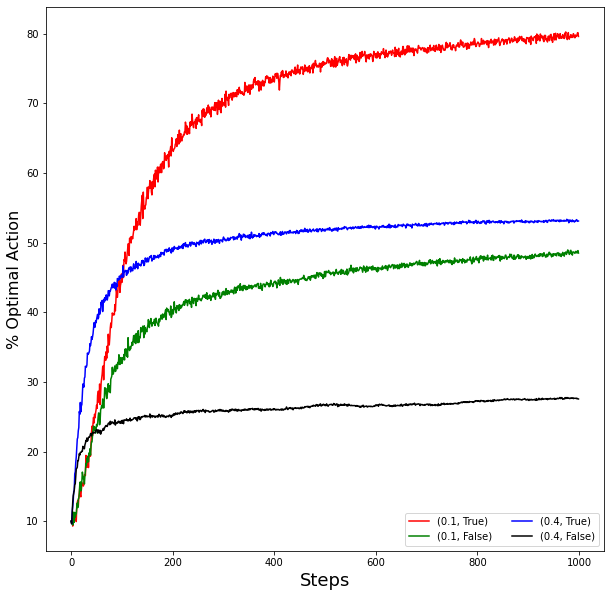

CPU times: user 188 ms, sys: 22.1 ms, total: 210 ms
Wall time: 2min 59s


In [8]:
%%time
with multiprocessing.Manager() as manager:
    global_reward_list = []
    mp_objects = []
    apply_baseline = [True, False,True,False] 
    stepSize_list    = [0.1, 0.1, 0.4, 0.4]
    color_list      = ['r', 'g', 'b', 'k']
    
    for index,step_size in enumerate(stepSize_list):
        global_reward_list.append(manager.list())
        mp_objects.append(multiprocessing.Process(target=gradient_bandit,
                                                  args=(steps, n_bandit, n_lever,
                                                        step_size,apply_baseline[index],
                                                        testbed, initial_reward_estimates,
                                                        global_reward_list[len(global_reward_list)-1])) )
    for index in range(len(mp_objects)):
        mp_objects[index].start()

    for index in range(len(mp_objects)):
        mp_objects[index].join()
        
    plt.figure(figsize=(10,10))
    plt.xlabel('Steps', fontsize=18)
    plt.ylabel('% Optimal Action', fontsize=16)
    for  index in range(len(mp_objects)):
        plt.plot(np.arange(steps),global_reward_list[index][0],label=(stepSize_list[index],apply_baseline[index]), color=color_list[index])
    
    plt.legend(loc='lower right', ncol=2)
    
    plt.show()